# Maine Hospital Service Area Analysis

### Background and Objective

Hospitals provide care ranging from basic treatments to critical life-saving surgeries and work to make these services as easily accessible as possible to the state's population. Hospitals are typically built in high population areas with multiple hospitals often being built next to each other in major cities to help alleviate patient overflow. While urban areas almost always offer readily accessible healthcare within a reasonable commute, suburban and rural areas tend to be further away from hospitals resulting in long commute times. With this in mind, the objective of this project is to analyze the current hospital coverage of Maine and determine which locations would benefit from a new hospital construction.

### Conceptual Model

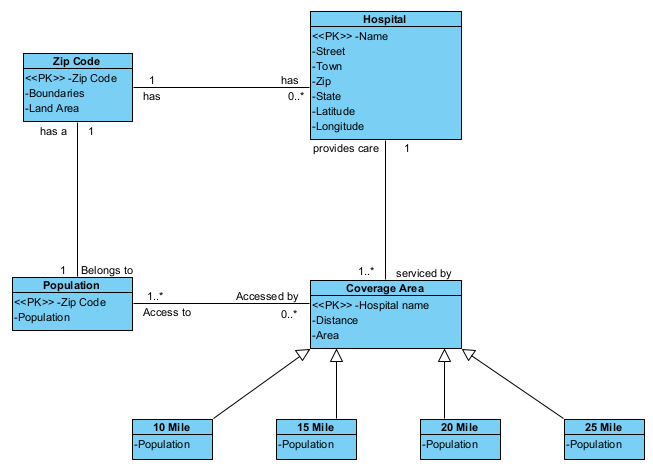

The hospital objects provide care for 1 to many coverage areas and each coverage area is serviced by one hospital. Each hospital has a coverage area for 10, 15, 20, and 25 mile radii. The coverage areas are accessed by one or more populations and the populations have access to 0 or more coverage areas. Each population belongs to a zip code and each zip code has a population associated with it. Finally, each zip code has 0 or many hospitals in its boundary and each hospital belongs to exactly 1 zip code.

### Data Sources

**Hospital Data:** http://www.themha.org/Our-Members/Member-Hopsitals
Used a list of Maine hospitals and their locations to fill out the name, street, town, zip, and state portions of the hospital table. Also used google maps to get latitude and longitude coordinates for all the hospital locations. Some addresses listed on the member-hospital website were not accurate but these were corrected if an alternative address was found on google maps.

**Population Data:** https://www.maine-demographics.com/zip_codes_by_population
Maine Demographics had a table already containing each Maine zip code along with their respective population totals. Data is from the 2021 american community survey so vallues are not reflective of real time population numbers from the current year but will suffice for this analysis.

**Zip code Shapefile:** https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
imported United States zip code shapefile from census.gov containing each zip code in the United States, their respective boundaries as a polygon, and the land area for each boundary. it's possible boundaries have changed slightly for some of these zip codes but these will still suffice for the objective of this project.

### Methodology and Results

##### Initial Setup

To start off, I obtained the hospital and population data and converted them into .csv files. With the hospital csv file, I created a new feature class for the information stored in the csv file and used a cursor to parse all the data into the feature class. This resulted in a new feature class with points for each hospital in Maine.

In [2]:
import arcpy
import os
from arcpy import env

#create filepaths
projectpath = r'C:\Users\mistw\Documents\ArcGIS\Projects\Hospital'
gdbFilepath = r'C:\Users\mistw\Documents\ArcGIS\Projects\Hospital\Hospital.gdb'
hospitalFilepath = r'C:\Users\mistw\Documents\ArcGIS\Projects\Hospital\Hospitals.csv'

#specify workplace enviornment
arcpy.env.workspace = gdbFilepath
arcpy.env.overwriteOutput = True

#specify spatial reference (WGS 84)
sr=arcpy.SpatialReference(4269)

#create hospital feature class
outFCPt = gdbFilepath + '\hospitals'
geometry_type = "POINT"
arcpy.CreateFeatureclass_management(os.path.dirname(outFCPt),
                                        os.path.basename(outFCPt), 
                                        "Point", spatial_reference=sr)

#add fields to hospital FC
arcpy.AddField_management(outFCPt, "name", "String", field_precision=30)
arcpy.AddField_management(outFCPt, "street", "String", field_precision=30)
arcpy.AddField_management(outFCPt, "town", "String", field_precision=30)
arcpy.AddField_management(outFCPt, "zip", "String", field_precision=30)
arcpy.AddField_management(outFCPt, "state", "String", field_precision=30)
arcpy.AddField_management(outFCPt, "latitude", "Float", field_precision=30)
arcpy.AddField_management(outFCPt, "longitude", "Float", field_precision=30)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\hospitals'>

In [3]:
coordinates = arcpy.Array()
names = []
streets = []
towns = []
hzips = []
states = []
lats = []
lons = []
pzips = []
populations = []

#open hospital file and extract lat and lon
with open(hospitalFilepath) as file:
    #remove header
    header=file.readline()
    
    #extract lattitude and longitude values
    for line in file:
        linesegment=line.split(",")
        
        #add values to column arrays
        names.append(linesegment[0])
        streets.append(linesegment[1])
        towns.append(linesegment[2])
        hzips.append(linesegment[3])
        states.append(linesegment[4])
        lats.append(float(linesegment[5]))
        lons.append(float(linesegment[6]))
        
        #create point with latitude and longitude values and add to coordinates
        point = arcpy.Point(float(linesegment[6]), float(linesegment[5]))
        coordinates.append(point)
        
#set up insert cursor for point feature class and add coordinates dates and times
with arcpy.da.InsertCursor(outFCPt,('SHAPE@XY', 'name', 'street', 'town', 'zip', 'state', 'latitude', 'longitude'))as icur2:
    for index, p in enumerate(coordinates):
        icur2.insertRow([p, names[index], streets[index], towns[index], hzips[index], states[index], lats[index], lons[index]])

After creating the hospital feature class and importing it into the geodatabase, I imported the population csv file into the project as a file geodatabase table. I also imported the zip code shape file with all the zip code land areas. Using the zip code as a join key, I combined the population data into the shapefile which removed the out of state zip codes while also adding a population column to the Maine zip codes. This new shapefile could then display the population density of all the zip codes using 5 classes of natural breaks in the data.

In [4]:
#import Populations.csv file
arcpy.conversion.TableToGeodatabase(
    Input_Table = projectpath + '\Populations.csv',
    Output_Geodatabase = gdbFilepath
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb'>

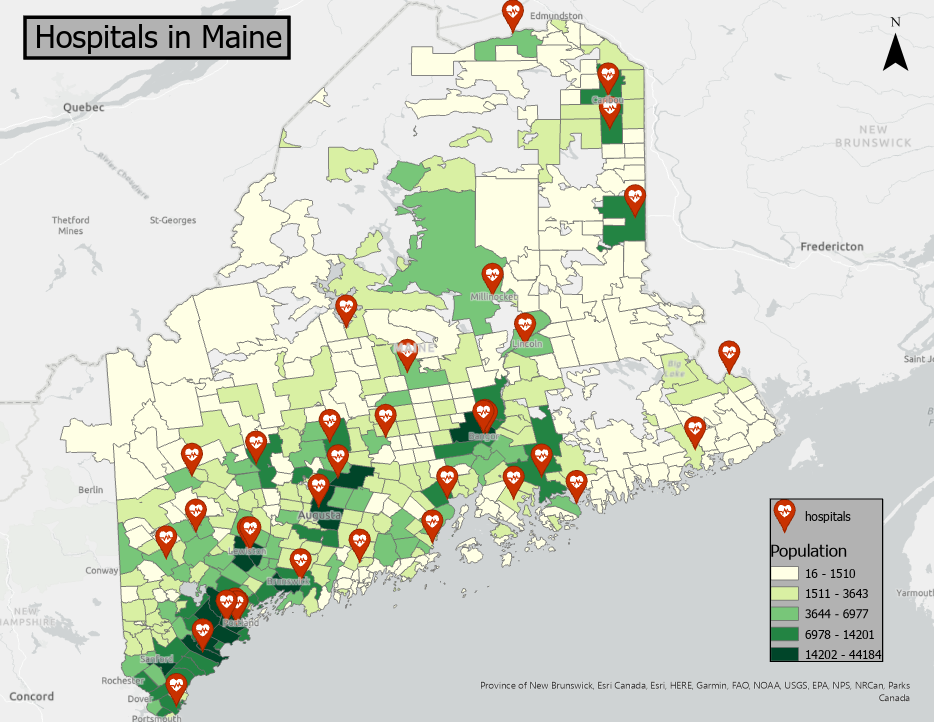

With hospital locations established along with zip code populations and land areas, the coverage areas can now be determined. I chose to do 4 different buffers to showcase the current coverage area of Maine. These Buffers will be used to show the coverage area of each hospital for populations within 10(red), 15(orange), 20(yellow), and 25(blue) miles of the hospital.

In [9]:
#Creates a 10 mile buffer using hospital points as the input feature
arcpy.analysis.Buffer(
    in_features="hospitals",
    out_feature_class= gdbFilepath + '\hospitals_Buffer_10',
    buffer_distance_or_field="10 MilesInt",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="GEODESIC"
)

#Creates a 15 mile buffer using hospital points as the input feature
arcpy.analysis.Buffer(
    in_features="hospitals",
    out_feature_class= gdbFilepath + '\hospitals_Buffer_15',
    buffer_distance_or_field="15 MilesInt",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="GEODESIC"
)

#Creates a 20 mile buffer using hospital points as the input feature
arcpy.analysis.Buffer(
    in_features="hospitals",
    out_feature_class= gdbFilepath + '\hospitals_Buffer_20',
    buffer_distance_or_field="20 MilesInt",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="GEODESIC"
)

#Creates a 25 mile buffer using hospital points as the input feature
arcpy.analysis.Buffer(
    in_features="hospitals",
    out_feature_class= gdbFilepath + '\hospitals_Buffer_25',
    buffer_distance_or_field="25 MilesInt",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="GEODESIC"
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\hospitals_Buffer_25'>

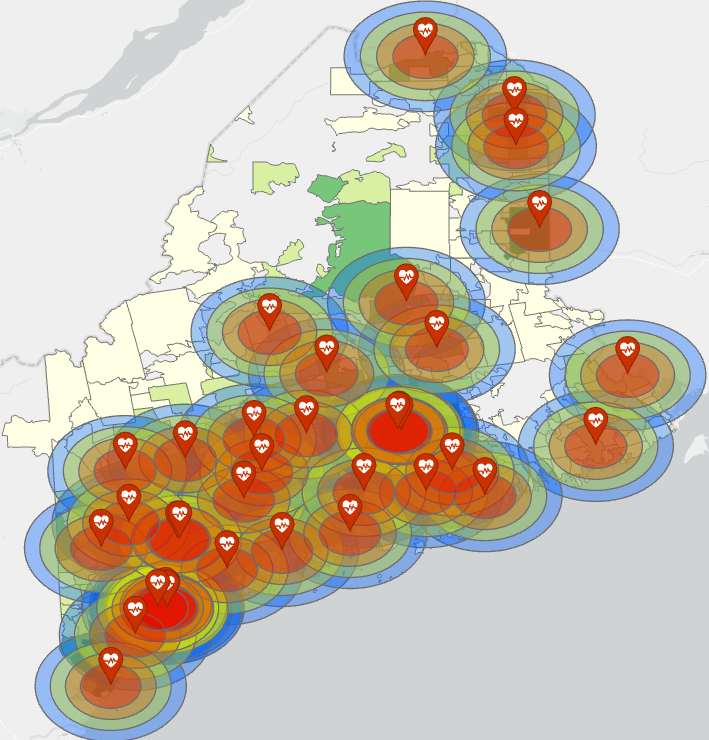

These buffers show the coverage range of each hospital; however, several of them reach areas outside of Maine which are not of concern. To address this, an intersection between each buffer area and the zip code layer will be performed to create an accurate representation of land coverage. In addition, Each hospital coverage area overlaps with multiple zip code areas with most overlaps only containing portions of the zip code area. To address this discrepancy and get more accurate models of the population coverage, each land segment within the boundary will have its geometry calculated. This value will represent the total land area of each zip code within the boundary. This polygon area value can then be ratiod against the total zip code land area and multiplied by the population to get a more accurate estimate of population coverage. This same process will occur for each boundary range to get estimates at each interval.

Formula for population within boundary: !Populations_Population! * (!Polygon_Area! / !cb_2018_us_zcta510_500k_1_ALAND10!)

In [9]:
def formLayers(buffer):
    
    #intersects buffer with populations by zip code
    arcpy.analysis.Intersect(
    in_features="hospitals_Buffer_" + buffer +" #;Population_By_Zip #",
    out_feature_class= gdbFilepath + '\hospitals_Buffer_Intersect_' + buffer,
    join_attributes="ALL",
    cluster_tolerance=None,
    output_type="INPUT"
    )
    
    #add PolygonArea field to buffer
    arcpy.management.AddField(
        in_table=gdbFilepath + '\hospitals_Buffer_Intersect_' + buffer,
        field_name="Polygon_Area",
        field_type="DOUBLE",
        field_precision=None,
        field_scale=None,
        field_length=None,
        field_alias="",
        field_is_nullable="NULLABLE",
        field_is_required="NON_REQUIRED",
        field_domain=""
    )

    #add Area_Pop field to buffer
    arcpy.management.AddField(
        in_table=gdbFilepath + '\hospitals_Buffer_Intersect_' + buffer,
        field_name="Area_Pop",
        field_type="DOUBLE",
        field_precision=None,
        field_scale=None,
        field_length=None,
        field_alias="",
        field_is_nullable="NULLABLE",
        field_is_required="NON_REQUIRED",
        field_domain=""
    )

    #calculate geodesic area in square meters to match zip code population land area
    #populates Polygon_Area field
    arcpy.management.CalculateGeometryAttributes(
        in_features=gdbFilepath + '\hospitals_Buffer_Intersect_' + buffer,
        geometry_property="Polygon_Area AREA_GEODESIC",
        length_unit="",
        area_unit="SQUARE_METERS",
        coordinate_system='GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
        coordinate_format="SAME_AS_INPUT"
    )

    #Calculate Area_pop by multiplying population by Polygon_Area/zipcode area
    #populates Area_pop field
    arcpy.management.CalculateField(
        in_table=gdbFilepath + '\hospitals_Buffer_Intersect_' + buffer,
        field="Area_Pop",
        expression="!Populations_Population! * (!Polygon_Area! / !cb_2018_us_zcta510_500k_1_ALAND10!)",
        expression_type="PYTHON3",
        code_block="",
        field_type="TEXT",
        enforce_domains="NO_ENFORCE_DOMAINS"
    )

    #generate statistics for total coverage of each hospital
    arcpy.analysis.Statistics(
        in_table=gdbFilepath + '\hospitals_Buffer_Intersect_' + buffer,
        out_table=gdbFilepath + '\hospitals_Buffer__Statistics_' + buffer,
        statistics_fields="Area_Pop SUM",
        case_field="name",
        concatenation_separator=""
    )
    
formLayers("10")
formLayers("15")
formLayers("20")
formLayers("25")

##### 10 Mile Buffer 

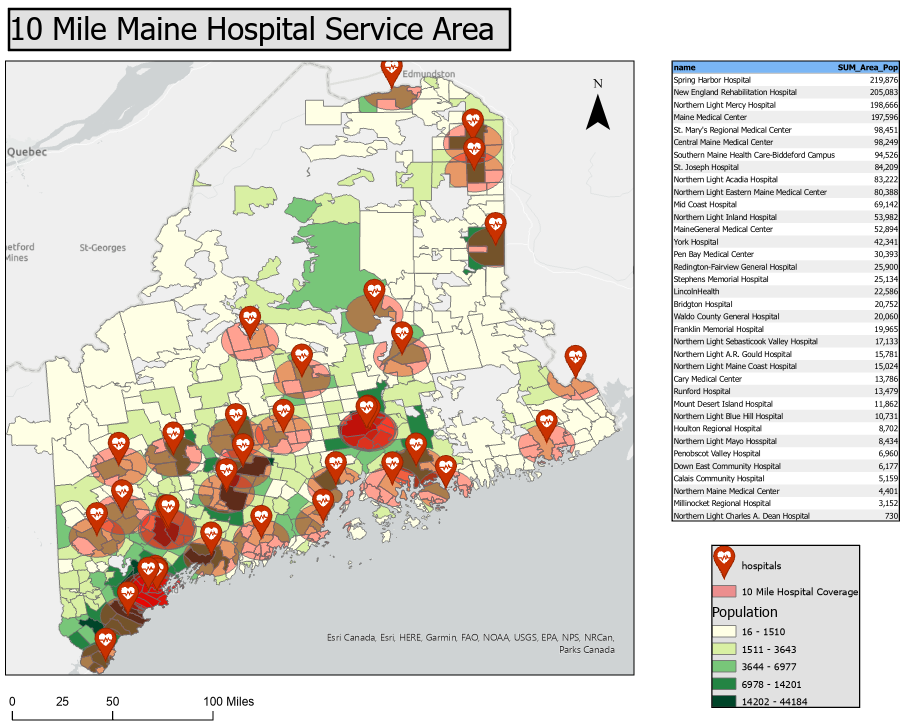

The 10 mile service area covers the more population dense locations with several hospitals being within range of over one-hundred thousand people. These hospitals with larger service areas are located in major cities such as Bangor and Portland and also have overlapping service areas with other hospitals near them. There are a lot of open gaps currently with the 10 mile buffer with numerous zip code populations that could have a 10 mile travel distance. I have chosen 3 potential locations which I believe will provide substantial added hospital coverage to Maine's current 10 mile hospital service area. To compare the current state with potential hospitals I will create a point feature class for locations I believe would benefit most at this current service area coverage. After the points are created, a 10 mile buffer creation from the points followed by an intersection of the buffer and the zip code populations can be performed to get an estimate of the total population coverage of the potential hospitals. These potential hospital buffers however can overlap with the current hospital service areas. Since I want to get a measurement of the increased service area each hospital would provide, a pairwise erase will also be performed to remove the areas that are already in an existing hospital's service area. This value can be used later to find what increase in coverage each of the potential hospitals would provide to the state of Maine.

In [15]:
#create buffer around potential hospitals
arcpy.analysis.Buffer(
    in_features="potential_hospitals_10",
    out_feature_class=gdbFilepath + '\PotentialHospitals_Buffer_10',
    buffer_distance_or_field="10 MilesInt",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="GEODESIC"
)

#intersects potential hospital buffers with populations by zip code
arcpy.analysis.Intersect(
    in_features = "PotentialHospitals_Buffer_10 #;Population_By_Zip #",
    out_feature_class = gdbFilepath + '\phospitals_Buffer_Intersect_10',
    join_attributes = "ALL",
    cluster_tolerance = None,
    output_type = "INPUT"
)

#pairwise erase overlapping service areas
arcpy.analysis.PairwiseErase(
    in_features="phospitals_Buffer_Intersect_10",
    erase_features=gdbFilepath + '\hospitals_Buffer_Intersect_10',
    out_feature_class=gdbFilepath + '\phospitals_Buf_PairwiseErase_10',
    cluster_tolerance=None
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\phospitals_Buf_PairwiseErase_10'>

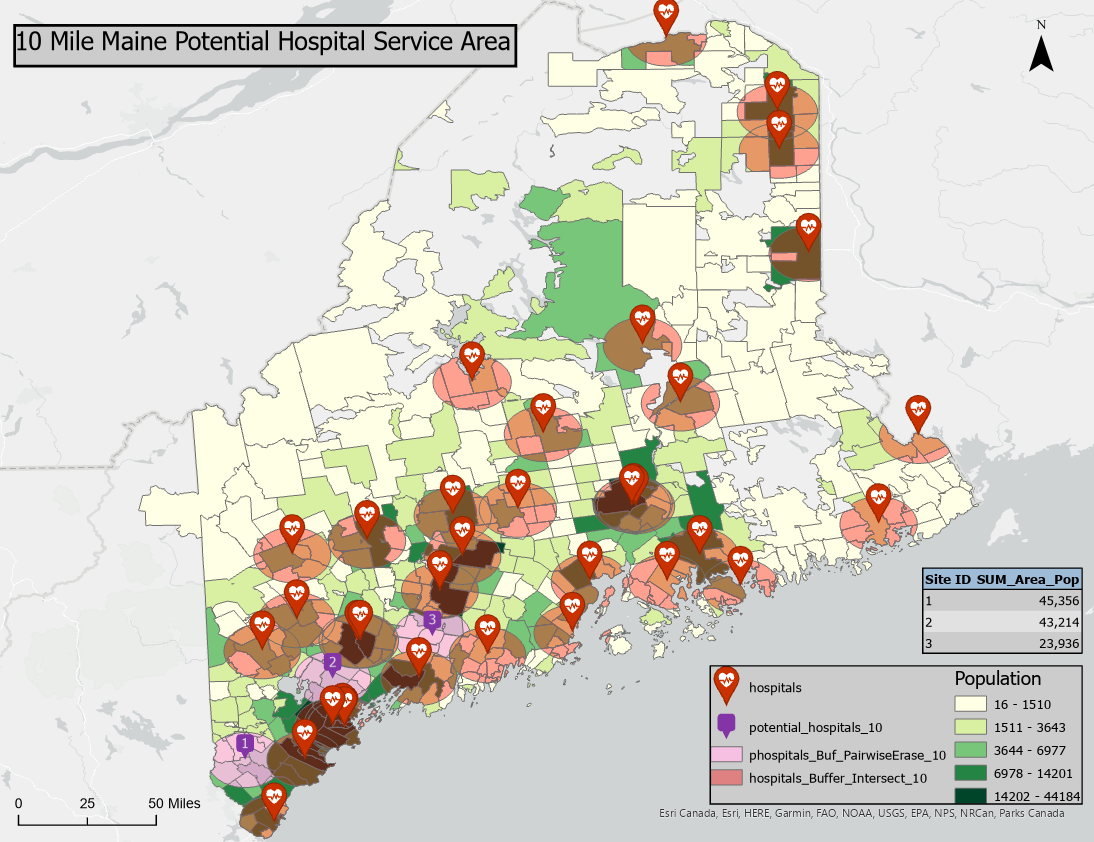

Site 1 had the largest population coverage improvement at 45,356 with Site 2 being close behind. Site 3 unfortunately did not provide much improvement. With Maine's current population of 1.372 million, site 1 would result in a 3.3% increase to Maine's 10 mile coverage. The numbers calculated for the current Maine 10 mile service area do not show total Maine coverage due to the overlaps counting groups of populations multiple times. Rather those numbers indicate how many people can reach the respective hospital by traveling 10 miles. To see what percentage of the population is within 10 miles of a hospital, the identical population values can be removed from the service area population.

In [16]:
#delete duplicate population counts from overlapping buffers
arcpy.management.DeleteIdentical(
    in_dataset="hospitals_Buffer_Intersect_10",
    fields="Area_Pop",
    xy_tolerance=None,
    z_tolerance=0
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\hospitals_Buffer_Intersect_10'>

Taking the sum of all the area values after duplicates were deleted results in a total Maine coverage of 975,967. Maine's current population is roughly 1,372,000. This results in 71.13% of Maine's population being within a 10 mile distance of a hospital. Adding a hospital at site 1 would result in a 74.43% 10 mile coverage.

##### 15 Mile Buffer 

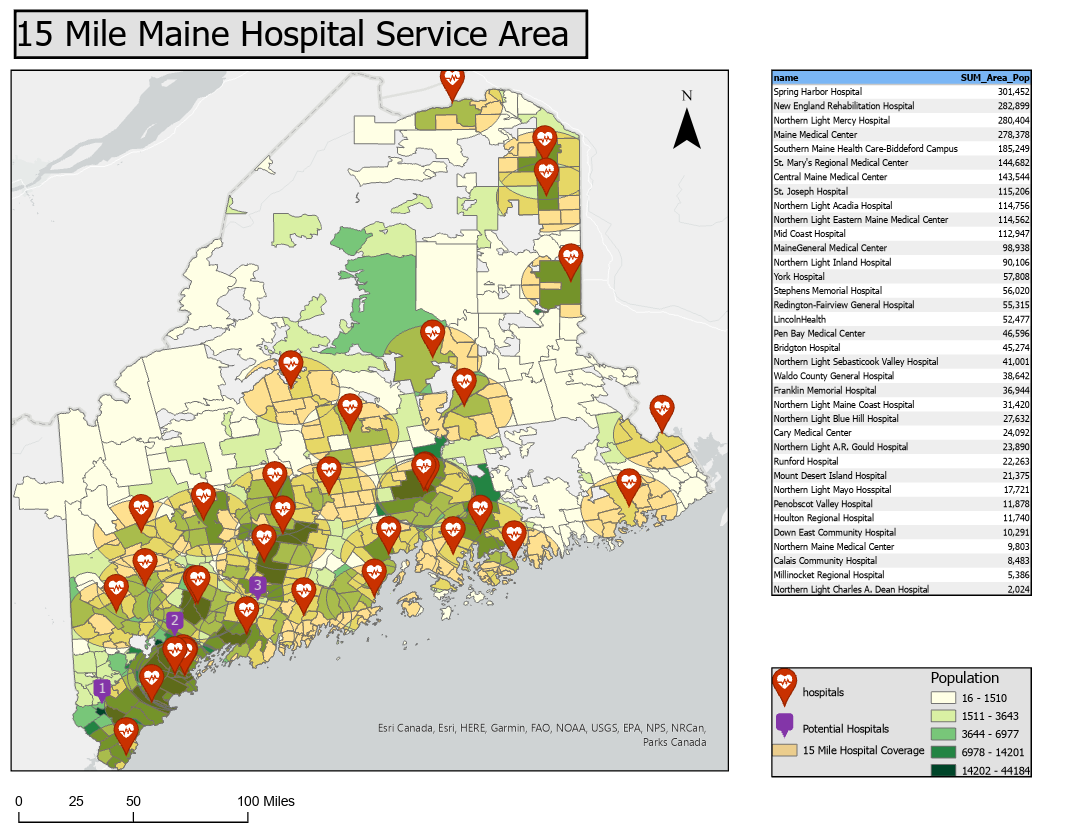

The 15 Mile service area of the hospitals covers almost all of the high density zip codes with few remaining dark patches. This range also covers the more mid dense areas while also showing gaps in the coverage that can be considered for potential hospitals. Sites 2 and 3 from the 10 mile service area are being covered at 15 miles so alternatives will be considered for this range. Site 1 is still in an uncovered area and will just need to be moved northwards for better results.

In [22]:
#create buffer around potential hospitals
arcpy.analysis.Buffer(
    in_features="potential_hospitals_15",
    out_feature_class=gdbFilepath + '\PotentialHospitals_Buffer_15',
    buffer_distance_or_field="15 MilesInt",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="GEODESIC"
)

#intersects potential hospital buffers with populations by zip code
arcpy.analysis.Intersect(
    in_features = "PotentialHospitals_Buffer_15 #;Population_By_Zip #",
    out_feature_class = gdbFilepath + '\phospitals_Buffer_Intersect_15',
    join_attributes = "ALL",
    cluster_tolerance = None,
    output_type = "INPUT"
)

#pairwise erase overlapping service areas
arcpy.analysis.PairwiseErase(
    in_features="phospitals_Buffer_Intersect_15",
    erase_features=gdbFilepath + '\hospitals_Buffer_Intersect_15',
    out_feature_class=gdbFilepath + '\phospitals_Buf_PairwiseErase',
    cluster_tolerance=None
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\PotentialHospitals_Buffer_15'>

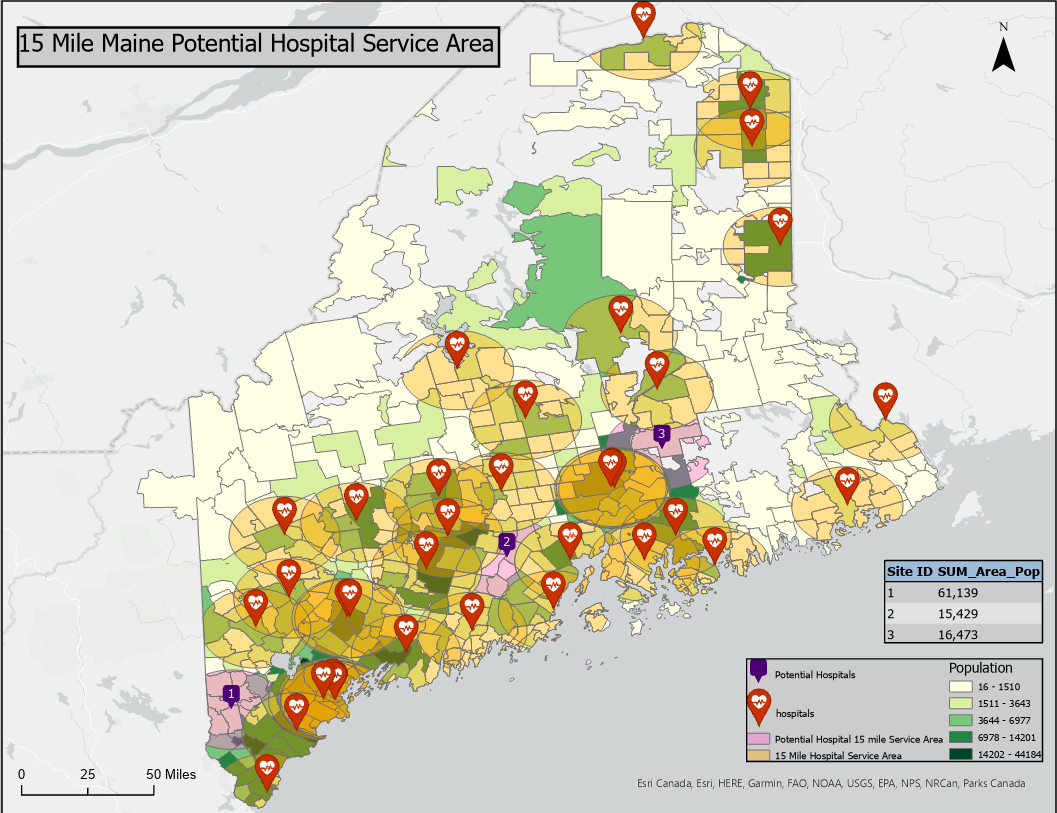

Of the three potential hospital locations, Site 1 beat out the other two sites in terms of increased population coverage within a 15 mile range. With Maine's current 1.372 million population, a new hospital at Site 1 would result in a 4.45% increase in 15 mile hospital service range. This new site 1 location would provide service to 61,139 additional people which would place it as the 14th best hospital in terms of population within its service area. Again to find the current 15 mile coverage range for Maine, duplicate overlapping populations will first need to be removed from the current 15 mile service area buffer.

In [31]:
#delete duplicate population counts from overlapping buffers
arcpy.management.DeleteIdentical(
    in_dataset="hospitals_Buffer_Intersect_15",
    fields="Area_Pop",
    xy_tolerance=None,
    z_tolerance=0
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\hospitals_Buffer_Intersect_15'>

removing the duplicates and taking the summation of populations indicates a total of 1,258,367 Maine residents are within a 15 mile range of a hospital. This equates to a 91.71% of Maine's population being within 15 miles of a hospital. Adding a hospital at site 1 would result in a total 15 mile coverage area of 96.16%.

##### 20 Mile Buffer 

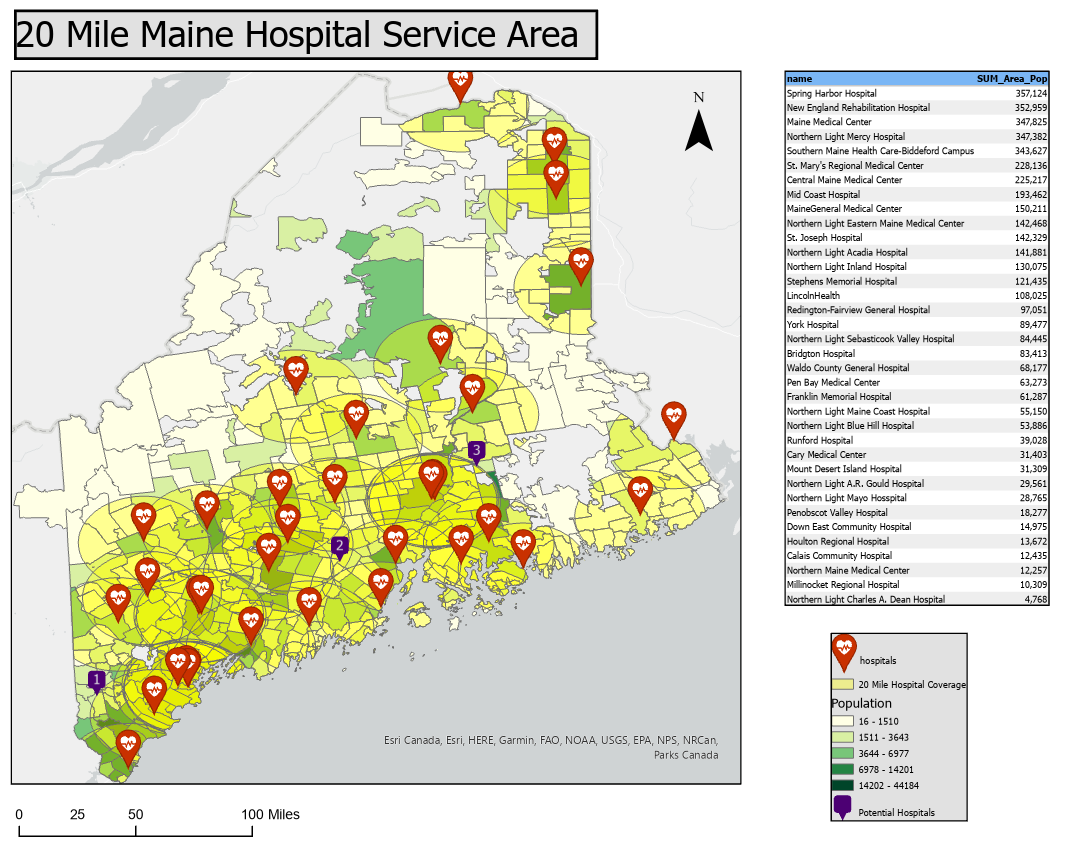

At the 20 mile buffer, two of the previous potential sites are covered by the current 20 mile hospital service area and as such they will not make good locations at this range. Site 1 is still however able to accommodate the few remaining mid-population areas and will be left for this range. After selecting a few alternative locations, the points will need a 20 mile buffer created, an intersection performed on them with the zip code populations, and a pairwise erase to remove the current hospital service area numbers from the results. 

In [3]:
#create buffer around potential hospitals
arcpy.analysis.Buffer(
    in_features="Potential_Hospitals_20",
    out_feature_class=gdbFilepath + '\PotentialHospitals_Buffer_20',
    buffer_distance_or_field="20 MilesInt",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="GEODESIC"
)

#intersects potential hospital buffers with populations by zip code
arcpy.analysis.Intersect(
    in_features = "PotentialHospitals_Buffer_20 #;Population_By_Zip #",
    out_feature_class = gdbFilepath + '\phospitals_Buffer_Intersect_20',
    join_attributes = "ALL",
    cluster_tolerance = None,
    output_type = "INPUT"
)

#pairwise erase overlapping service areas
arcpy.analysis.PairwiseErase(
    in_features="phospitals_Buffer_Intersect_20",
    erase_features=gdbFilepath + '\hospitals_Buffer_Intersect_20',
    out_feature_class=gdbFilepath + '\phospitals_PairwiseErase_20',
    cluster_tolerance=None
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\phospitals_PairwiseErase_20'>

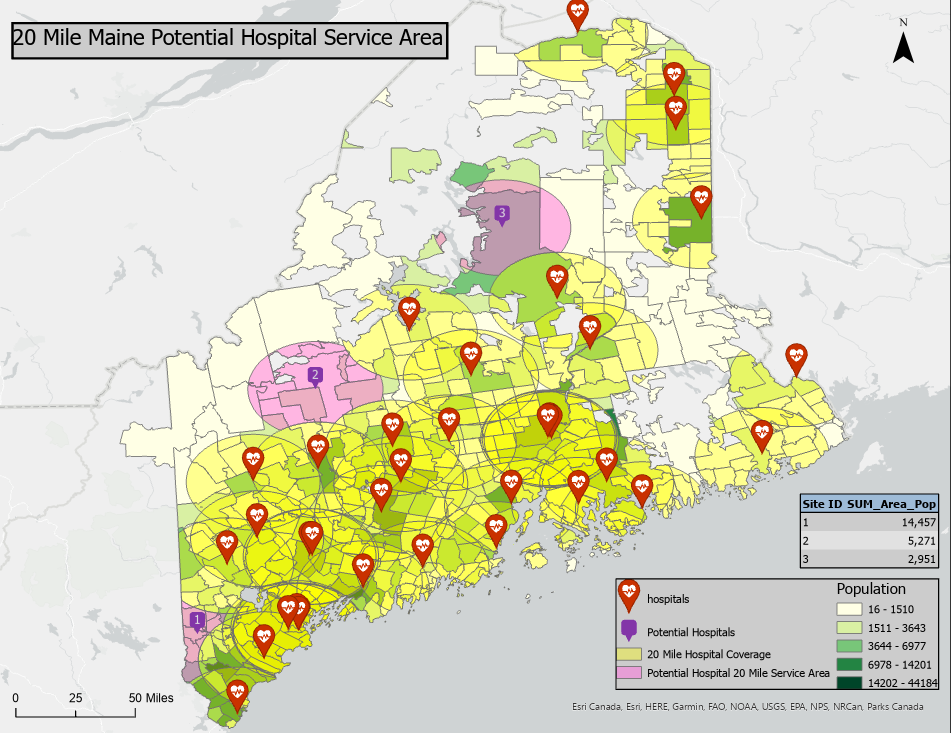

Site 1 has had its potential service population reduced substantially but it is still greater than the other two alternatives that were tried and remains the best option when considering a 20 mile service area. It results in 14,457 additional people being within 20 miles of a hospital that were not previously which would be a 1.05% increase overall. Again to find the current coverage, the duplicate population counts will need to be removed from the table.

In [5]:
#delete duplicate population counts from overlapping buffers
arcpy.management.DeleteIdentical(
    in_dataset="hospitals_Buffer_Intersect_20",
    fields="Area_Pop",
    xy_tolerance=None,
    z_tolerance=0
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\hospitals_Buffer_Intersect_20'>

Summing the population values this time results in 1,351,437 people being within 20 miles of a hospital which is 98.5% of Maine's total population. Adding a hospital at site 1 would result in 99.55% of Maine's population being within 20 miles of a hospital.

##### 25 Mile Buffer 

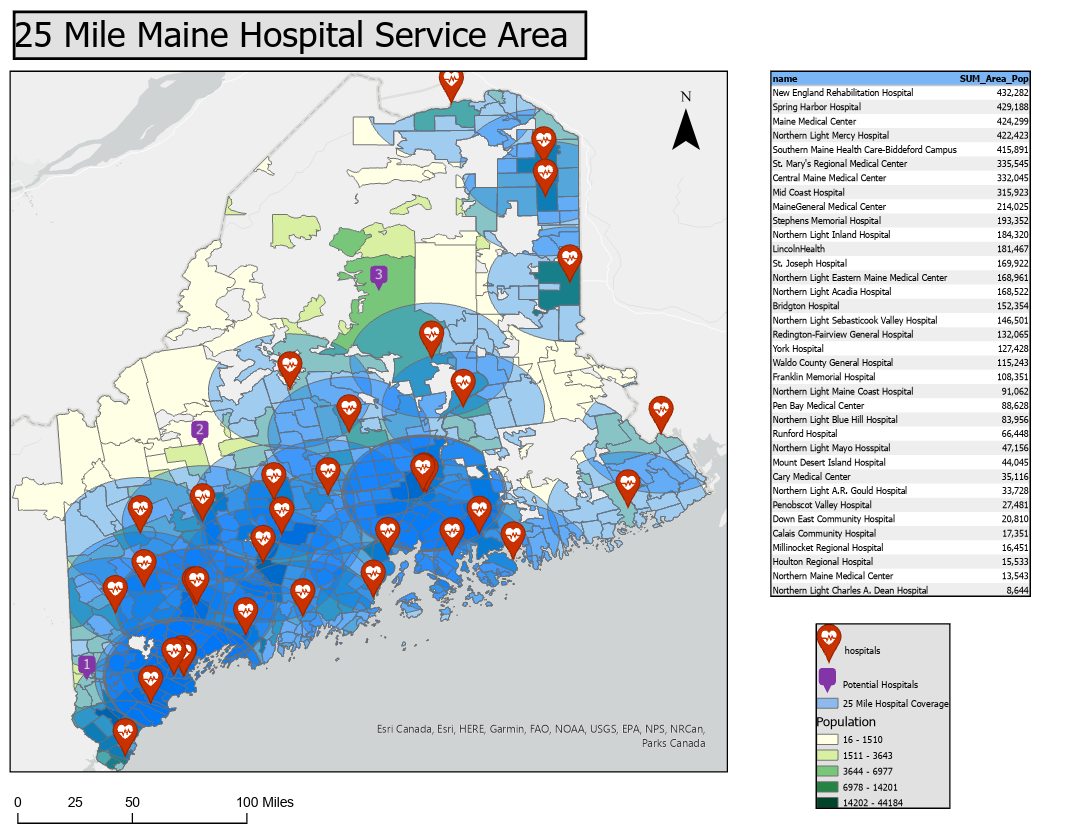

The final buffer range covers almost all of Maine at this stage with minimal remaining population sets. Site 1 is also almost completely covered. Sites 2 and 3 provided less than a 0.5% population coverage and with reduced area at those sites now they will offer even less population coverage. As there is not sufficient population remaining at this buffer range to justify a new hospital, I will instead skip to see what the total population hospital coverage of Maine is at 25 miles by again deleting duplicate area estimates.

In [10]:
#delete duplicate population counts from overlapping buffers
arcpy.management.DeleteIdentical(
    in_dataset="hospitals_Buffer_Intersect_25",
    fields="Area_Pop",
    xy_tolerance=None,
    z_tolerance=0
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\hospitals_Buffer_Intersect_25'>

Summing the service area populations this time results in a total coverage of 1,360,293 people. This equates to 99.15% of Maine's total population being within a 25 mile range of a hospital.

#### Site 1 Reanalysis @ 10 miles

Site 1 in the 10 mile buffer section had a large population but was quickly covered up at the 15 mile buffer section. Furthermore, the site 1 location in the 15 mile section had a larger population than the 10 mile section, which is mainly due to the increased buffer range; but, this fact advocates for the hospital to be built more northward as it will lead to a better population coverage at greater ranges.

In [27]:
#create buffer around potential hospitals
arcpy.analysis.Buffer(
    in_features="site1",
    out_feature_class=gdbFilepath + '\site1_Buffer_10',
    buffer_distance_or_field="10 MilesInt",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="GEODESIC"
)

#intersects potential hospital buffers with populations by zip code
arcpy.analysis.Intersect(
    in_features = "site1_Buffer_10 #;Population_By_Zip #",
    out_feature_class = gdbFilepath + '\site1_Buffer_Intersect_10',
    join_attributes = "ALL",
    cluster_tolerance = None,
    output_type = "INPUT"
)

#pairwise erase overlapping service areas
arcpy.analysis.PairwiseErase(
    in_features="site1_Buffer_Intersect_10",
    erase_features=gdbFilepath + '\hospitals_Buffer_Intersect_10',
    out_feature_class=gdbFilepath + '\site1_Buf_PairwiseErase_10',
    cluster_tolerance=None
)

#add PolygonArea field to buffer
arcpy.management.AddField(
    in_table=gdbFilepath + '\site1_Buf_PairwiseErase_10',
    field_name="Polygon_Area",
    field_type="DOUBLE",
    field_precision=None,
    field_scale=None,
    field_length=None,
    field_alias="",
    field_is_nullable="NULLABLE",
    field_is_required="NON_REQUIRED",
    field_domain=""
)

#add Area_Pop field to buffer
arcpy.management.AddField(
    in_table=gdbFilepath + '\site1_Buf_PairwiseErase_10',
    field_name="Area_Pop",
    field_type="DOUBLE",
    field_precision=None,
    field_scale=None,
    field_length=None,
    field_alias="",
    field_is_nullable="NULLABLE",
    field_is_required="NON_REQUIRED",
    field_domain=""
)

#calculate geodesic area in square meters to match zip code population land area
#populates Polygon_Area field
arcpy.management.CalculateGeometryAttributes(
    in_features=gdbFilepath + '\site1_Buf_PairwiseErase_10',
    geometry_property="Polygon_Area AREA_GEODESIC",
    length_unit="",
    area_unit="SQUARE_METERS",
    coordinate_system='GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
    coordinate_format="SAME_AS_INPUT"
)

#Calculate Area_pop by multiplying population by Polygon_Area/zipcode area
#populates Area_pop field
arcpy.management.CalculateField(
    in_table=gdbFilepath + '\site1_Buf_PairwiseErase_10',
    field="Area_Pop",
    expression="!Populations_Population! * (!Polygon_Area! / !cb_2018_us_zcta510_500k_1_ALAND10!)",
    expression_type="PYTHON3",
    code_block="",
    field_type="TEXT",
    enforce_domains="NO_ENFORCE_DOMAINS"
)
#generate statistics for total coverage of each hospital
arcpy.analysis.Statistics(
    in_table=gdbFilepath + '\site1_Buf_PairwiseErase_10',
    out_table=gdbFilepath + '\site1_Buffer__Statistics_10',
    statistics_fields="Area_Pop SUM",
    case_field="ORIG_FID",
    concatenation_separator=""
)

<Result 'C:\\Users\\mistw\\Documents\\ArcGIS\\Projects\\Hospital\\Hospital.gdb\\site1_Buffer__Statistics_10'>

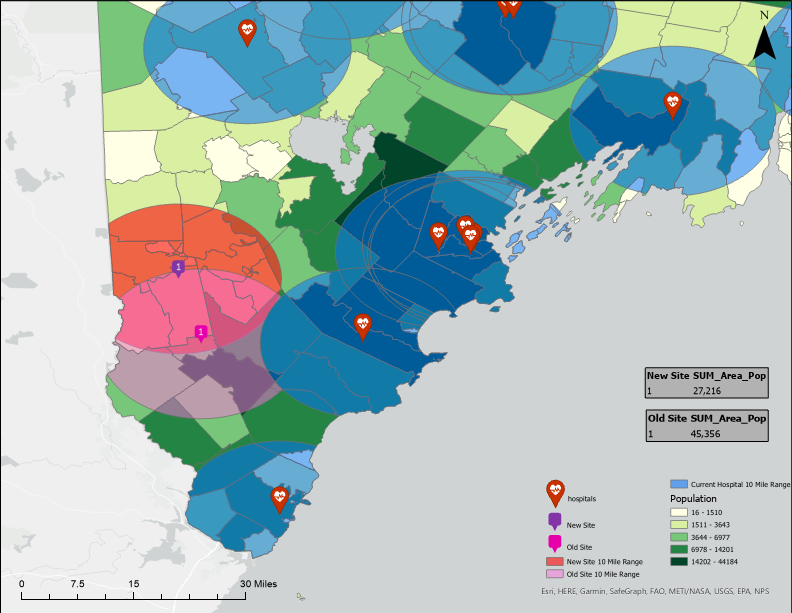

After creating a new point for site 1 at the 15 mile buffer location and recalculating the total population covered by this area, it was determined that site 1 would provide 27,216 additional people with 10 mile coverage which equates to a 1.98% increase at the 10 mile service area. While this is lower than the original amount, it allows better growth into the 15 and 20 mile ranges.

### Summary

Overall the Maine hospital service area is already within range of the majority of the population with over 70% of people being within 10 miles of a hospital, over 90% being within 15 miles of a hospital, and over 98% being within 20 miles of a hospital. Of the potential sites analyzed, the best by far seems to be the site 1 initially analyzed in the 15 mile buffer range. This site provides a 1.98% improvement in service area at the 10 mile buffer range, a 4.45% improvement at the 15 mile range, and a 1.05% improvement at the 20 mile range. 

While this analysis was heavily focused on distance from hospital care, other factors could also be considered in a future analysis such as putting more emphasis towards aged populations as they're more reliant on this care, or taking income differences into account since lower income households are less likely to own a car making hospital trips more unreliable even within 10 miles. Furthermore, hospitals have varying staffing and bed availability which could also be taken into account to determine at what threshold a new hospital would be more beneficial if installed next to other hospitals to accommodate needed staffing and bedding in more populated areas.

In retrospect, considering distance as the only factor, Maine does not seem to be in any urgent need for new hospitals and seems to have a very well designed system in place to accommodate the vast majority of its people. I don't believe the overall potential service area increase discussed here completely justifies a new hospital; but, it could be considered further if hospitals particularly in the southern region begin requiring additional assistance from other hospitals to accommodate an influx of patients.